# Transfer Learning for Image Classification

# 0. Imports

In [15]:
import os, pickle

# for keeping track of loops
from tqdm import tqdm

# basic libraries
import numpy as np
import pandas as pd

# import pytorch
import torch
import torch.nn as nn

# import torchvision modules
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, ToTensor, Resize, CenterCrop, Normalize
from torch.utils.data import DataLoader, Dataset

# sklearn modules
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# import pretrained models
import torchvision.models as models

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# setting the device to "mps" instead of default "cpu"
# device = torch.device("mps" if torch.backends.mps.is_available else "cpu")
device = torch.device("cuda" if torch.cuda.is_available else "cpu")


print(device)

cuda


# 1. Preparing Data

In [3]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    # train transform
    'train': Compose([
        RandomResizedCrop(224),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize(mean, std)
    ]),
    # test transform
    'test': Compose([
        Resize(256),
        RandomResizedCrop(224),
        ToTensor(),
        Normalize(mean, std)
    ])
}

In [4]:
raw_data_dir = '/kaggle/input/chicken-vs-duck-classification'
raw_data_dir

'/kaggle/input/chicken-vs-duck-classification'

In [6]:
# some hyper-parameters
batch_size = 16

# create datasets using ImageFolder
image_datasets = {x: ImageFolder(os.path.join(raw_data_dir, x), data_transforms[x]) for x in ['train', 'test']}

# create dataloaders
image_dataloaders = {'train':DataLoader(
                        dataset=image_datasets['train'],
                        batch_size=batch_size,
                        shuffle=True,
                    ),
                     'test':DataLoader(
                        dataset=image_datasets['test'],
                        batch_size=len(image_datasets['test']),
                        shuffle=True,
                    )}


data_sizes = {x:len(image_datasets[x])
                for x in ['train', 'test']}

print("Data Sizes:\n", data_sizes)

class_names = image_datasets['train'].classes
print("\nClass Names:\n", class_names)

Data Sizes:
 {'train': 200, 'test': 50}

Class Names:
 ['chicken', 'duck']


In [7]:
# extracting the test dataset
X_test, y_test = next(iter(image_dataloaders['test']))
# move the data to GPU
X_test, y_test = X_test.to(device), y_test.to(device)
# print the shape
print(X_test.shape, y_test.shape)

torch.Size([50, 3, 224, 224]) torch.Size([50])


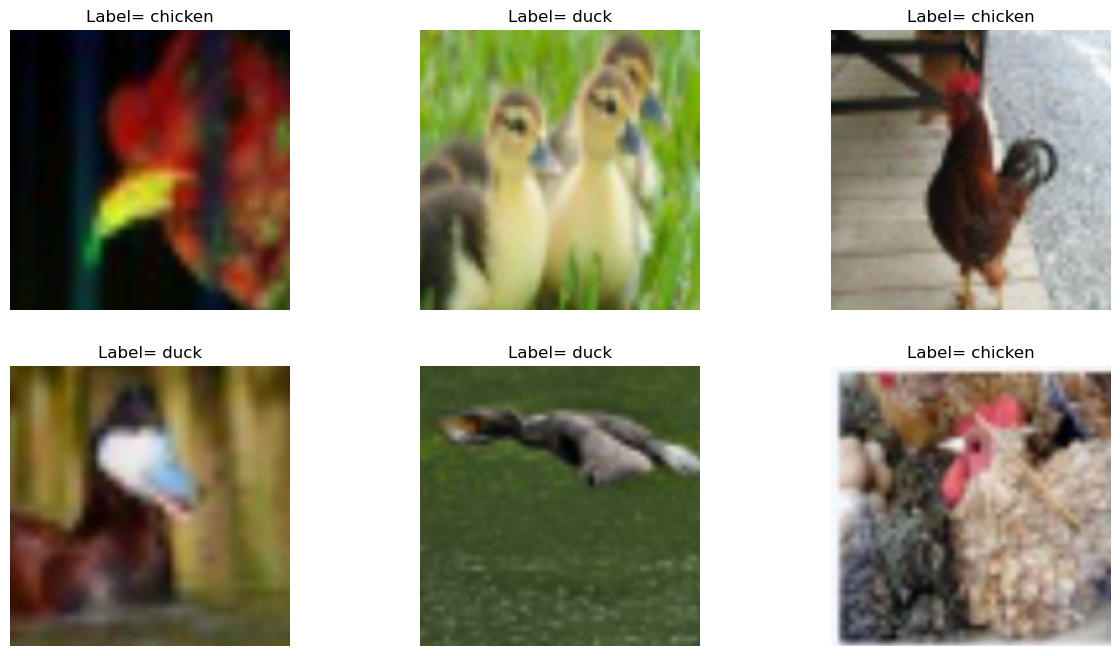

In [8]:
# visualize a few samples from the test data
plt.figure(figsize=(15,8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    # copy the image back to cpu to reshape
    img = X_test[i].cpu()
    # we have multi-channel image
    # pre-precoss the image before printing
    img = np.transpose(img, (1,2,0))
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.title("Label= " + class_names[y_test[i]])
    plt.grid(False)
    plt.axis(False)
plt.show()

# 2. Models

## 2.2 ResNet18

In [9]:
model_resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# freeze all the layers except the final FC Layer
for params in model_resnet18.parameters():
    params.requires_grad = False

# extract the input features size taken in by the last FC Layer
fc_inp_size = model_resnet18.fc.in_features

# reset the final FC Layer with new weights
model_resnet18.fc = nn.Linear(fc_inp_size, len(class_names))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [12]:
# create a directory named models, to store the saved models
models_dir = os.path.join(os.getcwd(), 'models')
! mkdir $models_dir

### 2.1.1 Training

  3%|▎         | 5/150 [00:03<01:29,  1.62it/s]

Epoch 5/150 Training Loss: 0.2844


  7%|▋         | 10/150 [00:06<01:24,  1.66it/s]

Epoch 10/150 Training Loss: 0.2217


 10%|█         | 15/150 [00:09<01:20,  1.68it/s]

Epoch 15/150 Training Loss: 0.2555


 13%|█▎        | 20/150 [00:12<01:17,  1.67it/s]

Epoch 20/150 Training Loss: 0.3072


 17%|█▋        | 25/150 [00:15<01:20,  1.56it/s]

Epoch 25/150 Training Loss: 0.2367
Saved model weights at models/resnet18_epoch25.pth


 20%|██        | 30/150 [00:18<01:14,  1.61it/s]

Epoch 30/150 Training Loss: 0.2226


 23%|██▎       | 35/150 [00:21<01:15,  1.52it/s]

Epoch 35/150 Training Loss: 0.2104


 27%|██▋       | 40/150 [00:24<01:08,  1.59it/s]

Epoch 40/150 Training Loss: 0.2636


 30%|███       | 45/150 [00:27<01:03,  1.66it/s]

Epoch 45/150 Training Loss: 0.3411


 33%|███▎      | 50/150 [00:31<01:03,  1.57it/s]

Epoch 50/150 Training Loss: 0.1910
Saved model weights at models/resnet18_epoch50.pth


 37%|███▋      | 55/150 [00:34<00:57,  1.65it/s]

Epoch 55/150 Training Loss: 0.2227


 40%|████      | 60/150 [00:37<00:54,  1.64it/s]

Epoch 60/150 Training Loss: 0.2055


 43%|████▎     | 65/150 [00:40<00:51,  1.66it/s]

Epoch 65/150 Training Loss: 0.2189


 47%|████▋     | 70/150 [00:42<00:47,  1.69it/s]

Epoch 70/150 Training Loss: 0.1858


 50%|█████     | 75/150 [00:45<00:45,  1.64it/s]

Epoch 75/150 Training Loss: 0.3041
Saved model weights at models/resnet18_epoch75.pth


 53%|█████▎    | 80/150 [00:49<00:43,  1.60it/s]

Epoch 80/150 Training Loss: 0.2576


 57%|█████▋    | 85/150 [00:52<00:44,  1.46it/s]

Epoch 85/150 Training Loss: 0.2679


 60%|██████    | 90/150 [00:55<00:37,  1.60it/s]

Epoch 90/150 Training Loss: 0.2309


 63%|██████▎   | 95/150 [00:58<00:32,  1.69it/s]

Epoch 95/150 Training Loss: 0.2863


 67%|██████▋   | 100/150 [01:01<00:31,  1.59it/s]

Epoch 100/150 Training Loss: 0.2331
Saved model weights at models/resnet18_epoch100.pth


 70%|███████   | 105/150 [01:04<00:26,  1.67it/s]

Epoch 105/150 Training Loss: 0.2423


 73%|███████▎  | 110/150 [01:07<00:23,  1.70it/s]

Epoch 110/150 Training Loss: 0.2208


 77%|███████▋  | 115/150 [01:10<00:21,  1.63it/s]

Epoch 115/150 Training Loss: 0.2203


 80%|████████  | 120/150 [01:13<00:17,  1.67it/s]

Epoch 120/150 Training Loss: 0.2467


 83%|████████▎ | 125/150 [01:16<00:16,  1.55it/s]

Epoch 125/150 Training Loss: 0.2087
Saved model weights at models/resnet18_epoch125.pth


 87%|████████▋ | 130/150 [01:19<00:12,  1.65it/s]

Epoch 130/150 Training Loss: 0.2240


 90%|█████████ | 135/150 [01:22<00:09,  1.64it/s]

Epoch 135/150 Training Loss: 0.2468


 93%|█████████▎| 140/150 [01:26<00:06,  1.60it/s]

Epoch 140/150 Training Loss: 0.2580


 97%|█████████▋| 145/150 [01:29<00:03,  1.65it/s]

Epoch 145/150 Training Loss: 0.2746


100%|██████████| 150/150 [01:32<00:00,  1.62it/s]

Epoch 150/150 Training Loss: 0.2719
Saved model weights at models/resnet18_epoch150.pth


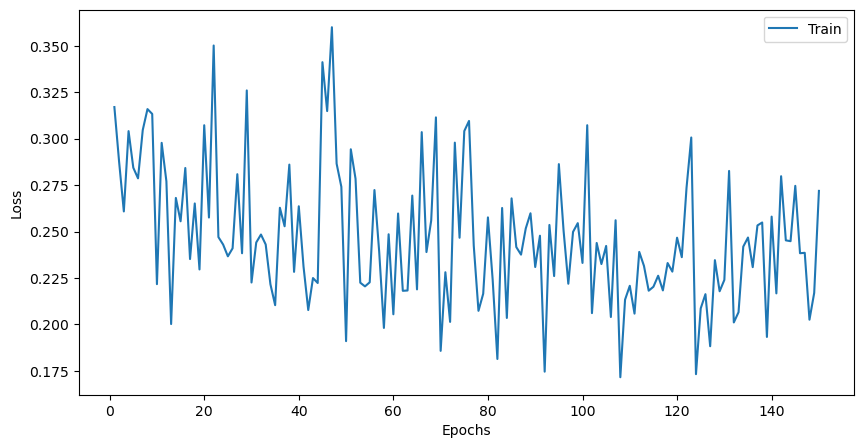

In [13]:
# set the hyper-parameters
num_epochs = 150
learning_rate = 0.001

# step sizes
print_step = 5
model_save_step = 25

# move the model to GPU
model_resnet18.to(device)

# define the loss function
criterion = nn.CrossEntropyLoss()

# define the optimizer
optimizer = torch.optim.Adam(model_resnet18.parameters(), lr=learning_rate)

# define the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

# store the training loss
train_losses = []

# training loop
for epoch in tqdm(range(num_epochs)):
    # set the model to training mode
    model_resnet18.train()

    # keep track of the epoch training loss
    epoch_loss = 0.0

    # loop over the training data in batches
    for inputs, labels in image_dataloaders['train']:
        # move the data to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model_resnet18(inputs)

        # calculate the loss
        loss = criterion(outputs, labels)

        # backward pass
        loss.backward()

        # optimize the weights
        optimizer.step()

        # update the epoch training loss
        epoch_loss += loss.item()
    
    # store the mean epoch loss
    train_losses.append(epoch_loss/len(image_dataloaders['train']))


    # print training information every `print_step` epochs
    if (epoch + 1) % print_step == 0:
        print("Epoch {}/{} Training Loss: {:.4f}".format(epoch+1, num_epochs, train_losses[-1]))
    
    # save the model weights every `model_save_size` epochs
    if (epoch + 1) % model_save_step == 0:
        torch.save(model_resnet18.state_dict(), os.path.join('models', 'resnet18_epoch{}.pth'.format(epoch+1)))
        print("Saved model weights at models/resnet18_epoch{}.pth".format(epoch+1))

# plot the training loss
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2.1.2 Testing

              precision    recall  f1-score   support

     chicken       0.84      0.84      0.84        25
        duck       0.84      0.84      0.84        25

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.84      0.84      0.84        50


Accuracy: 84.00%




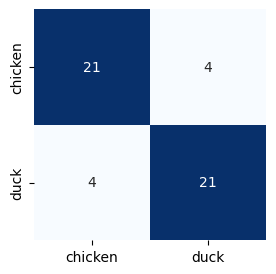

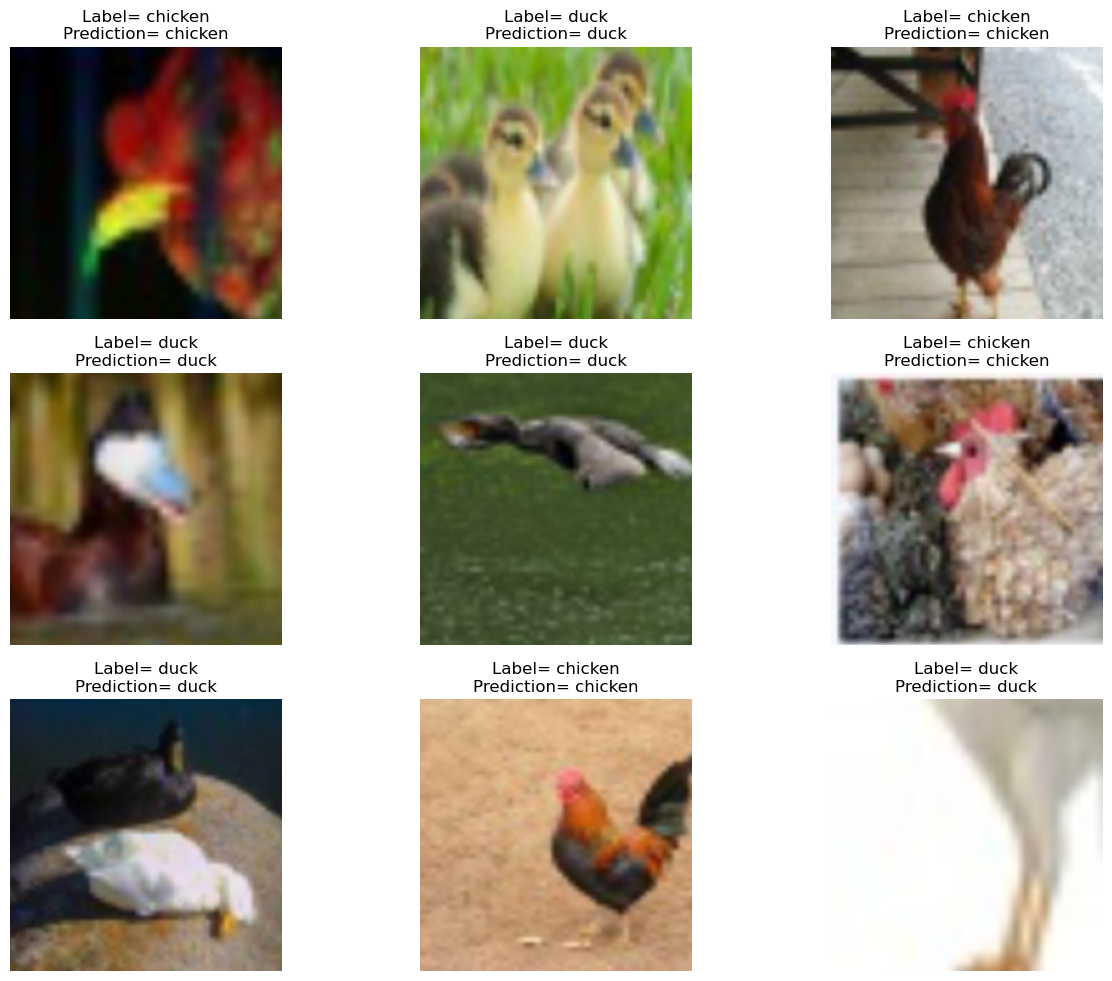

In [19]:
# testing the model on the test data

# set the model to evaluation mode
model_resnet18.eval()

# turn off gradients
with torch.no_grad():
    # make predictions
    outputs = model_resnet18(X_test)
    # get the maximum prediction across the rows
    _, preds = torch.max(outputs, 1)

# move the predictions and labels to cpu
preds = preds.cpu()
y_test = y_test.cpu()

# print the classification report
print(classification_report(y_test, preds, target_names=class_names))

# visualize the confusion matrix
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)

# print the accuracy
print("\nAccuracy: {:.2f}%".format(accuracy_score(y_test, preds)*100))
print("\n")

# visualize a few samples from the test data
plt.figure(figsize=(15,12))

# plot images in 3 rows and 3 columns
for i in range(9):
    plt.subplot(3, 3, i+1)
    # copy the image back to cpu to reshape
    img = X_test[i].cpu()
    # we have multi-channel image
    # pre-precoss the image before printing
    img = np.transpose(img, (1,2,0))
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.title("Label= {}\nPrediction= {}".format(class_names[y_test[i]], class_names[preds[i]]))
    plt.grid(False)
    plt.axis(False)

plt.show()

As we can observe, even with just `200` training examples, we are able to obtain a `~84%` accuracy on the test set.

## 2.2 VGG11 (with Batch Normalization)

In [22]:
model_vgg11_bn = models.vgg11_bn(weights=models.VGG11_BN_Weights.DEFAULT)

# freeze all the layers except the final FC Layer
for params in model_vgg11_bn.parameters():
    params.requires_grad = False

# extract the input features size taken in by the last FC Layer
fc_inp_size = model_vgg11_bn.classifier[-1].in_features

# reset the final FC Layer with new weights
model_vgg11_bn.classifier[-1] = nn.Linear(fc_inp_size, len(class_names))

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

### 2.2.1 Training

  3%|▎         | 5/150 [00:04<01:58,  1.23it/s]

Epoch 5/150 Training Loss: 0.3394


  7%|▋         | 10/150 [00:08<01:50,  1.26it/s]

Epoch 10/150 Training Loss: 0.2772


 10%|█         | 15/150 [00:12<01:48,  1.25it/s]

Epoch 15/150 Training Loss: 0.2528


 13%|█▎        | 20/150 [00:16<01:43,  1.25it/s]

Epoch 20/150 Training Loss: 0.3343


 16%|█▌        | 24/150 [00:19<01:42,  1.23it/s]

Epoch 25/150 Training Loss: 0.2684


 17%|█▋        | 25/150 [00:21<02:27,  1.18s/it]

Saved model weights at models/vgg11_bn_epoch25.pth


 20%|██        | 30/150 [00:25<01:42,  1.17it/s]

Epoch 30/150 Training Loss: 0.1810


 23%|██▎       | 35/150 [00:29<01:33,  1.22it/s]

Epoch 35/150 Training Loss: 0.2222


 27%|██▋       | 40/150 [00:33<01:28,  1.24it/s]

Epoch 40/150 Training Loss: 0.2527


 30%|███       | 45/150 [00:37<01:25,  1.23it/s]

Epoch 45/150 Training Loss: 0.2534


 33%|███▎      | 49/150 [00:40<01:19,  1.27it/s]

Epoch 50/150 Training Loss: 0.2278


 33%|███▎      | 50/150 [00:42<01:46,  1.07s/it]

Saved model weights at models/vgg11_bn_epoch50.pth


 37%|███▋      | 55/150 [00:46<01:20,  1.19it/s]

Epoch 55/150 Training Loss: 0.2100


 40%|████      | 60/150 [00:50<01:14,  1.21it/s]

Epoch 60/150 Training Loss: 0.1932


 43%|████▎     | 65/150 [00:54<01:12,  1.18it/s]

Epoch 65/150 Training Loss: 0.2560


 47%|████▋     | 70/150 [00:58<01:04,  1.24it/s]

Epoch 70/150 Training Loss: 0.2489


 49%|████▉     | 74/150 [01:02<00:59,  1.27it/s]

Epoch 75/150 Training Loss: 0.2247


 50%|█████     | 75/150 [01:03<01:20,  1.08s/it]

Saved model weights at models/vgg11_bn_epoch75.pth


 53%|█████▎    | 80/150 [01:07<00:58,  1.20it/s]

Epoch 80/150 Training Loss: 0.3304


 57%|█████▋    | 85/150 [01:11<00:52,  1.24it/s]

Epoch 85/150 Training Loss: 0.2050


 60%|██████    | 90/150 [01:15<00:48,  1.23it/s]

Epoch 90/150 Training Loss: 0.1905


 63%|██████▎   | 95/150 [01:19<00:44,  1.25it/s]

Epoch 95/150 Training Loss: 0.2840


 66%|██████▌   | 99/150 [01:23<00:41,  1.23it/s]

Epoch 100/150 Training Loss: 0.1704


 67%|██████▋   | 100/150 [01:25<00:59,  1.19s/it]

Saved model weights at models/vgg11_bn_epoch100.pth


 70%|███████   | 105/150 [01:29<00:38,  1.16it/s]

Epoch 105/150 Training Loss: 0.2396


 73%|███████▎  | 110/150 [01:33<00:31,  1.26it/s]

Epoch 110/150 Training Loss: 0.2085


 77%|███████▋  | 115/150 [01:37<00:28,  1.24it/s]

Epoch 115/150 Training Loss: 0.2174


 80%|████████  | 120/150 [01:41<00:23,  1.27it/s]

Epoch 120/150 Training Loss: 0.2406


 83%|████████▎ | 124/150 [01:44<00:20,  1.26it/s]

Epoch 125/150 Training Loss: 0.1371


 83%|████████▎ | 125/150 [01:46<00:27,  1.10s/it]

Saved model weights at models/vgg11_bn_epoch125.pth


 87%|████████▋ | 130/150 [01:50<00:17,  1.13it/s]

Epoch 130/150 Training Loss: 0.2795


 90%|█████████ | 135/150 [01:54<00:12,  1.25it/s]

Epoch 135/150 Training Loss: 0.2663


 93%|█████████▎| 140/150 [01:58<00:08,  1.17it/s]

Epoch 140/150 Training Loss: 0.1970


 97%|█████████▋| 145/150 [02:02<00:04,  1.25it/s]

Epoch 145/150 Training Loss: 0.2390


 99%|█████████▉| 149/150 [02:05<00:00,  1.25it/s]

Epoch 150/150 Training Loss: 0.2497


100%|██████████| 150/150 [02:07<00:00,  1.18it/s]

Saved model weights at models/vgg11_bn_epoch150.pth


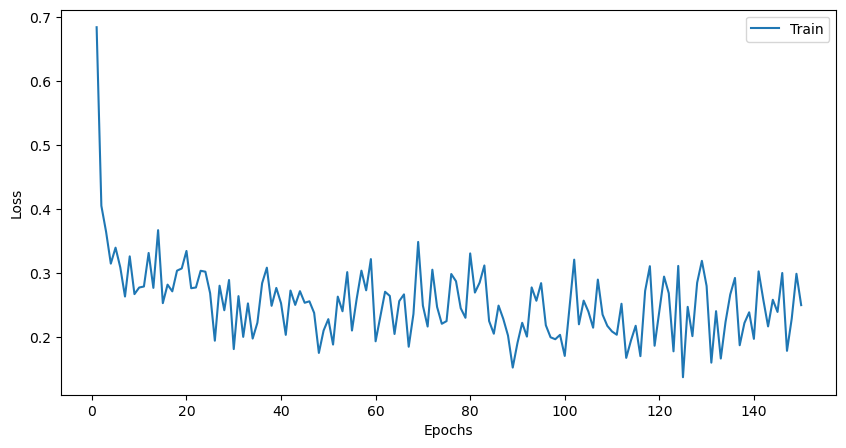

In [23]:
# set the hyper-parameters
num_epochs = 150
learning_rate = 0.001

# step sizes
print_step = 5
model_save_step = 25

# move the model to GPU
model_vgg11_bn.to(device)

# define the loss function
criterion = nn.CrossEntropyLoss()

# define the optimizer
optimizer = torch.optim.Adam(model_vgg11_bn.parameters(), lr=learning_rate)

# define the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

# store the training loss
train_losses = []

# training loop
for epoch in tqdm(range(num_epochs)):
    # set the model to training mode
    model_vgg11_bn.train()

    # keep track of the epoch training loss
    epoch_loss = 0.0

    # loop over the training data in batches
    for inputs, labels in image_dataloaders['train']:
        # move the data to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model_vgg11_bn(inputs)

        # calculate the loss
        loss = criterion(outputs, labels)

        # backward pass
        loss.backward()

        # optimize the weights
        optimizer.step()

        # update the epoch training loss
        epoch_loss += loss.item()
    
    # store the mean epoch loss
    train_losses.append(epoch_loss/len(image_dataloaders['train']))


    # print training information every `print_step` epochs
    if (epoch + 1) % print_step == 0:
        print("Epoch {}/{} Training Loss: {:.4f}".format(epoch+1, num_epochs, train_losses[-1]))
    
    # save the model weights every `model_save_size` epochs
    if (epoch + 1) % model_save_step == 0:
        torch.save(model_vgg11_bn.state_dict(), os.path.join('models', 'vgg11_bn_epoch{}.pth'.format(epoch+1)))
        print("Saved model weights at models/vgg11_bn_epoch{}.pth".format(epoch+1))

# plot the training loss
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2.2.2 Testing

              precision    recall  f1-score   support

     chicken       0.85      0.88      0.86        25
        duck       0.88      0.84      0.86        25

    accuracy                           0.86        50
   macro avg       0.86      0.86      0.86        50
weighted avg       0.86      0.86      0.86        50

Accuracy: 86.00%


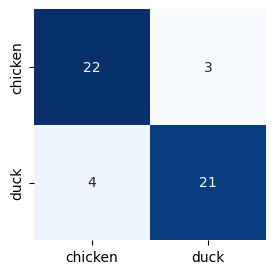

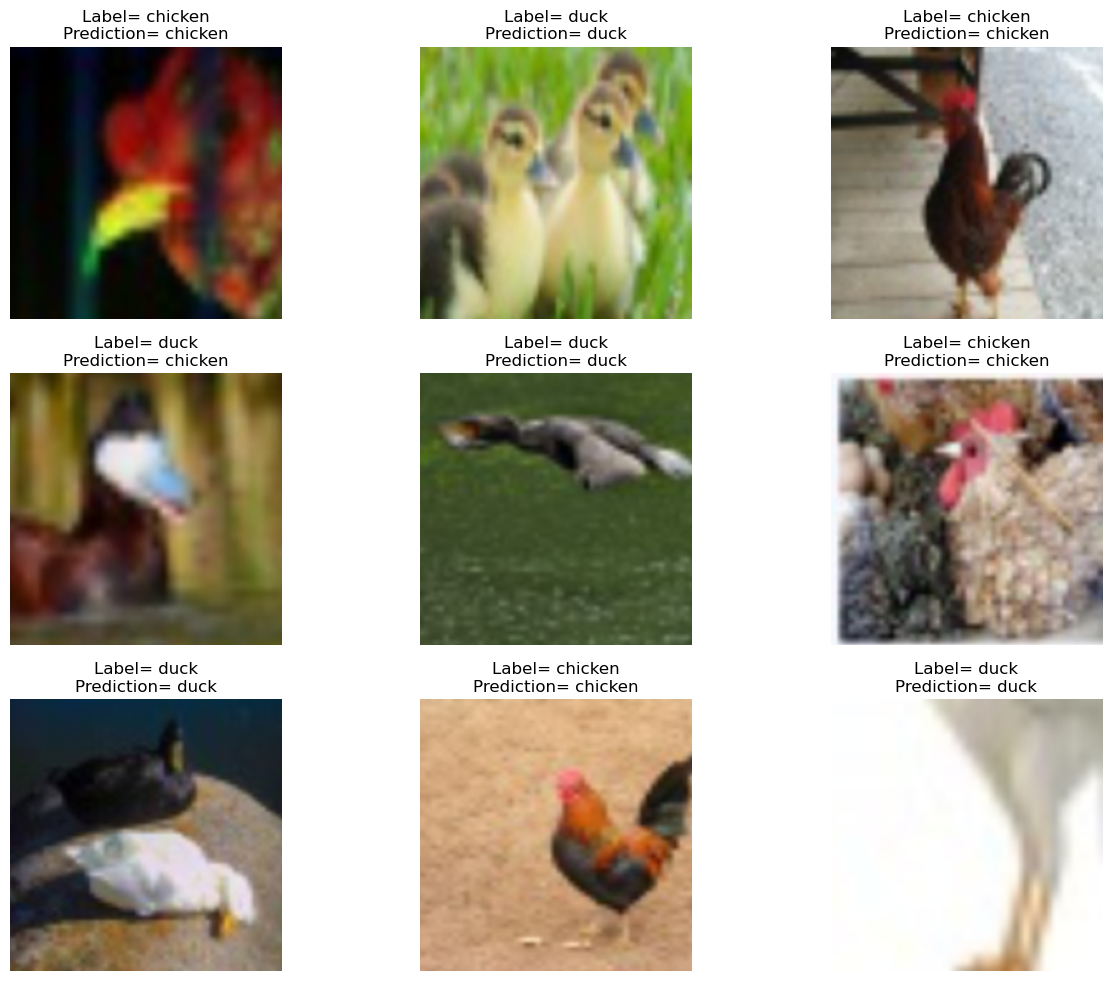

In [25]:
# testing the model on the test data

# set the model to evaluation mode
model_vgg11_bn.eval()

# turn off gradients
with torch.no_grad():
    # make predictions
    outputs = model_vgg11_bn(X_test)
    # get the maximum prediction across the rows
    _, preds = torch.max(outputs, 1)

# move the predictions and labels to cpu
preds = preds.cpu()
y_test = y_test.cpu()

# print the classification report
print(classification_report(y_test, preds, target_names=class_names))

# visualize the confusion matrix
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)

# print the accuracy
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, preds)*100))

# visualize a few samples from the test data
plt.figure(figsize=(15,12))

# plot images in 3 rows and 3 columns
for i in range(9):
    plt.subplot(3, 3, i+1)
    # copy the image back to cpu to reshape
    img = X_test[i].cpu()
    # we have multi-channel image
    # pre-precoss the image before printing
    img = np.transpose(img, (1,2,0))
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.title("Label= {}\nPrediction= {}".format(class_names[y_test[i]], class_names[preds[i]]))
    plt.grid(False)
    plt.axis(False)

plt.show()